In [1]:
import json
import os
import numpy as np
import glob
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def toTime(time):
    year, month, day = int(time[:4]), int(time[5:7]), int(time[8:10])
    hour, minute, second = int(time[11:13]), int(time[14:16]), int(time[17:19])

    if len(time) > 19:
        microsec = int(time[20:-1])
        return datetime.datetime(year, month, day, hour, minute, second, microsec)
    else:
        return datetime.datetime(year, month, day, hour, minute, second)

In [3]:
def fileTime(time):
    year, month, day = time[:4], time[5:7], time[8:10]
    hour, minute, second = time[11:13], time[14:16], time[17:19]
    
    return year+month+day+hour+minute+second

In [4]:
def genDuration(start, ptime, stime, sample_rate, length):
    
    # time: str -> datetime.datetime
    start, ptime, stime = toTime(start), toTime(ptime), toTime(stime)
    
    # ptime, stime 減去儀器開始時間，以得到具體在哪個 sample point
    diff_p, diff_s = ptime-start, stime-start
    sec_diff_p, microsec_diff_p = diff_p.seconds, diff_p.microseconds
    sec_diff_s, microsec_diff_s = diff_s.seconds, diff_s.microseconds
    
    p_trigger_sample = int((sec_diff_p+microsec_diff_p/1e+5)*sample_rate)
    s_trigger_sample = int((sec_diff_s+microsec_diff_s/1e+5)*sample_rate)

    # 生成 ground-truth
    gt = np.zeros(length)
    gt[p_trigger_sample:s_trigger_sample] = 1
    
    return gt

In [5]:
# 速度微分 -> 加速度
# 100.0: sampling_rate
def v_to_a(z, n, e, sample_rate):
    d_z = np.gradient(z, 1.0/sample_rate)
    d_n = np.gradient(n, 1.0/sample_rate)
    d_e = np.gradient(e, 1.0/sample_rate)

    return d_z, d_n, d_e

In [16]:
def toCSV(z, n, e, gt, ori_time, station, instrument, stage, root_save_path):
    to_write = np.vstack((e, n, z, gt))
    ori_time = fileTime(ori_time)
   
    # filename: 地震發生時間 + 測站名 + 儀器種類
    file_name = ori_time + '_' + station + '_' + instrument
    base_path = os.path.join(stage, file_name)
    print(os.path.join(root_save_path, base_path))
    #np.savetxt(base_path+'.csv', to_write, delimiter=',')

In [42]:
def check_wave(wave):
    if np.mean(wave) == 0.0 and np.var(wave) == 0.0:
        return False
    else:
        return True

### 取地震波形:
    
    1. 先檢查 s_arrival_time 是否有效(有些 pfile 中的值=0) && 篩選震央距離或震度來取 waveforms
        
    2. 取 Z, N, E, factor, p_arrival_time, s_arrival_time
    
    3. 確定資料類型是 Velocity or Acceleration，if Velocity: 微分成 acceleration
    
    4. Label 出 p-wave duration (ground-truth)
    
    5. 匯入 csv

In [44]:
def getSeisWave(p, root_save_path):
    for k in p.keys():
        try:
            # 看測站內有多少組波形資料
            n_data = p[k]['numberOfData']
            
            for w in range(n_data):
                # 若儀器失效或是沒有抓到 s波到時就不要存成訓練資料
                if (not p[k][str(w)]['DataAvailable']['instrument']) or (not p[k][str(w)]['DataAvailable']['Stime']) \
                    or (not p[k][str(w)]['DataAvailable']['pga']) or (not p[k][str(w)]['DataAvailable']['pgv']):
                    continue
                
                # 只挑 instrument=FBA
                if p[k][str(w)]['instrument'] != 'FBA':
                    continue
                    
                # get Z, N, E, convert to ndarray
                z, n, e = p[k][str(w)]['Z'], p[k][str(w)]['N'], p[k][str(w)]['E']
                z, n, e = np.array(z), np.array(n), np.array(e)
                
                # multiply z, n, e by factor
                z, n, e = z*p[k][str(w)]['factor'][0], n*p[k][str(w)]['factor'][1], e*p[k][str(w)]['factor'][2]
                
                # 檢查波形有效性
                if (not check_wave(z)) or (not check_wave(n)) or (not check_wave(e)):
                    continue
                
                # get the multiple attributes
                waveType = p[k][str(w)]['datatype']
                sampleRate = p[k][str(w)]['sampling_rate']
                starttime = p[k][str(w)]['starttime']
                ptime, stime = p[k][str(w)]['p_arrival_time'], p[k][str(w)]['s_arrival_time']
                
                # if datatype='velocity', 積分成 acceleration
                if waveType == 'velocity':
                    z, n, e = v_to_a(z, n, e, sampleRate)
                    
                # label p-wave duration
                gt = genDuration(starttime, ptime, stime, sampleRate, z.shape[0])
                draw(z, n, e, gt)
                # write into csv file
                ori_time, instrument = p['ori_time'], p[k][str(w)]['instrument']
                toCSV(z, n, e, gt, ori_time, k, instrument, 'seis', root_save_path)
                
        except Exception as e:
            pass
#             print(e)

In [30]:
def draw(z, n, e, gt):
    #plt.figure(figsize=(15, 10))
    plt.subplot(411)
    plt.plot(z)
    
    plt.subplot(412)
    plt.plot(n)
    
    plt.subplot(413)
    plt.plot(e)
    
    plt.subplot(414)
    plt.plot(gt)
    plt.show()

In [18]:
root = "/mnt/nas6/CWBDatasets/2020/"
root_save_path = "/mnt/nas7/weiwei/earthquake_RNN/newTrain/"
files = os.listdir(root)

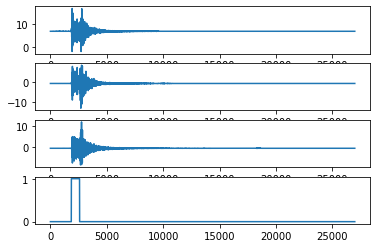

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ESA_FBA


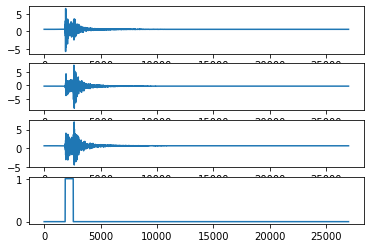

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWC_FBA


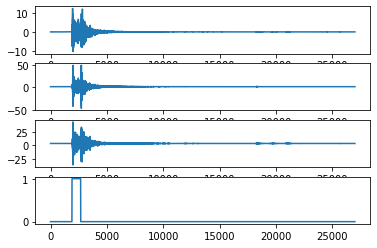

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ENA_FBA


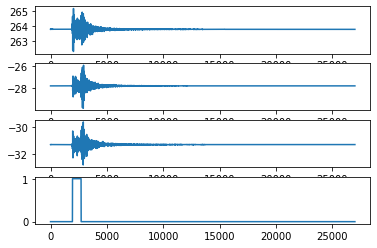

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NDS_FBA


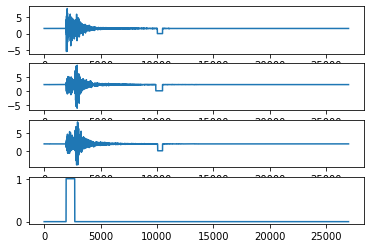

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NDS_FBA


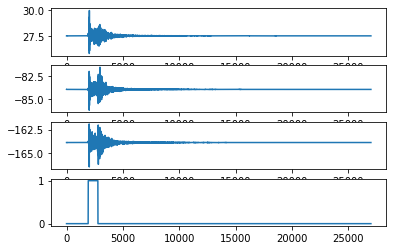

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EAH_FBA


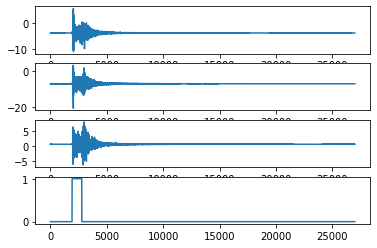

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EAH_FBA


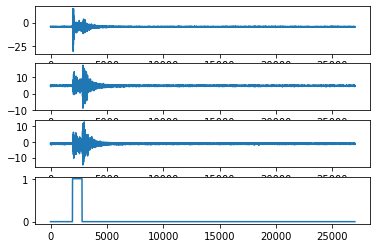

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EHP_FBA


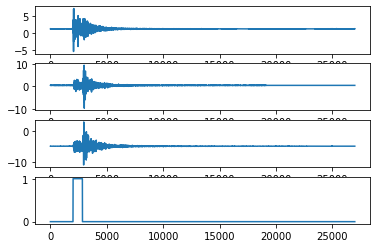

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ILA_FBA


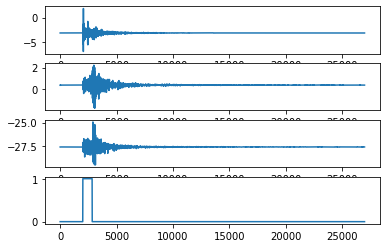

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ILA_FBA


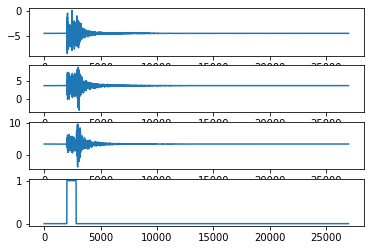

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWE_FBA


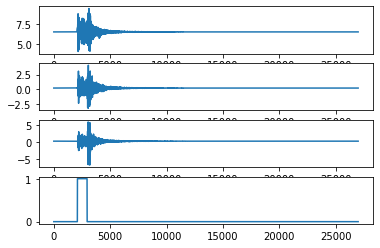

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NDT_FBA


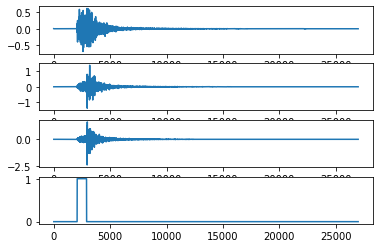

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TIPB_FBA


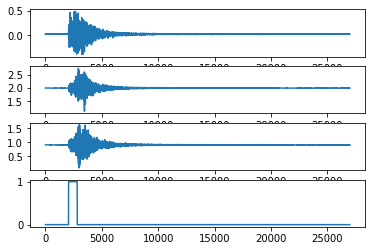

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWB1_FBA


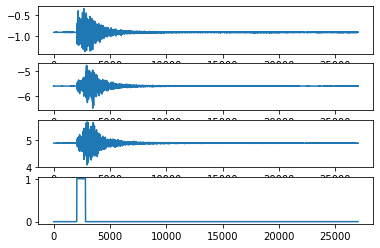

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWB1_FBA


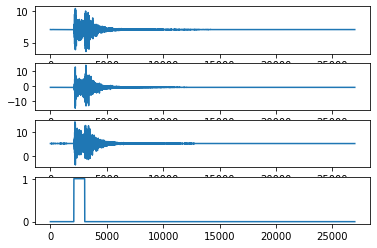

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ETL_FBA


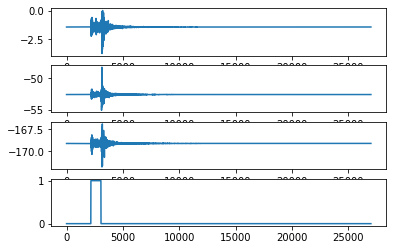

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NWL_FBA


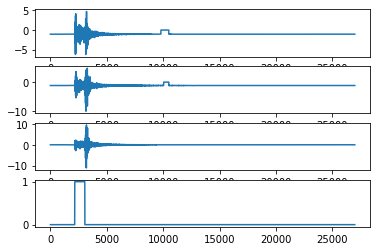

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NWL_FBA


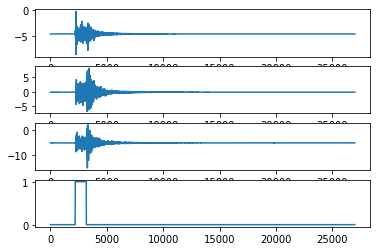

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NNS_FBA


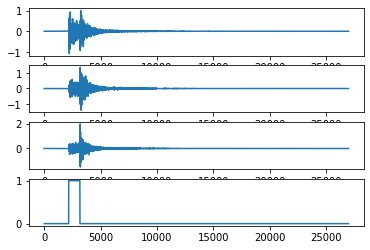

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ETLH_FBA


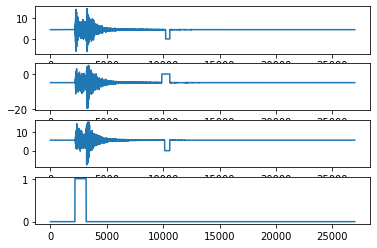

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ETLH_FBA


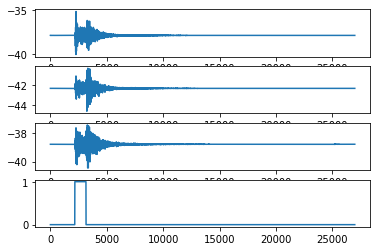

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWD_FBA


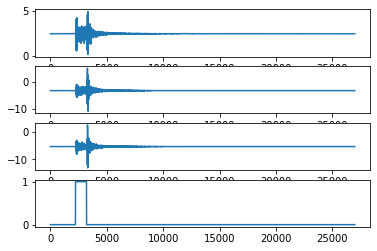

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NSK_FBA


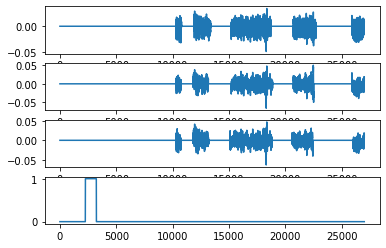

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NHDH_FBA


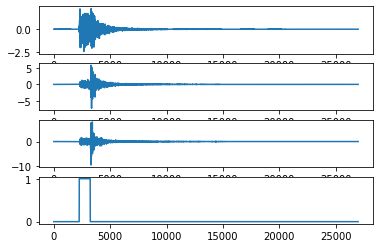

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NHDH_FBA


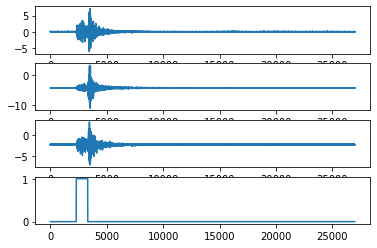

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NHY_FBA


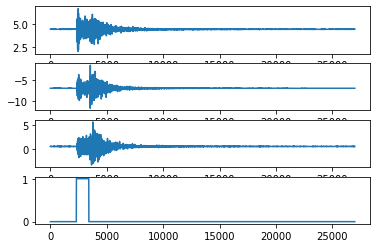

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_HWA_FBA


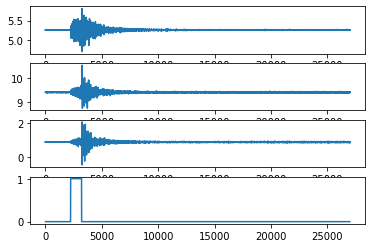

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NOU_FBA


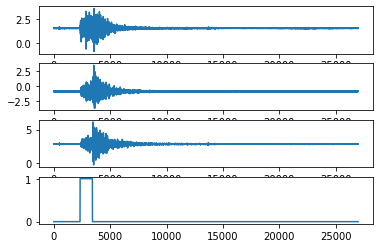

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_BAC_FBA


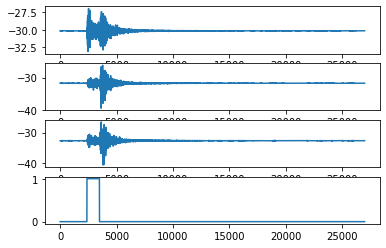

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EYL_FBA


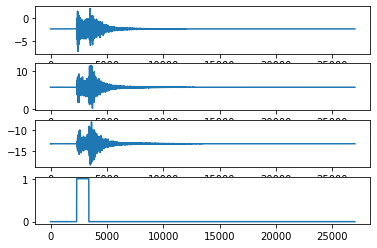

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ETM_FBA


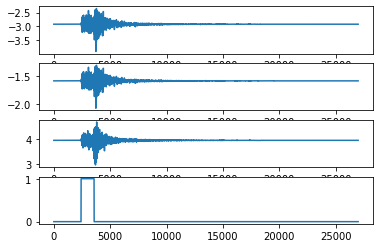

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_FUSS_FBA


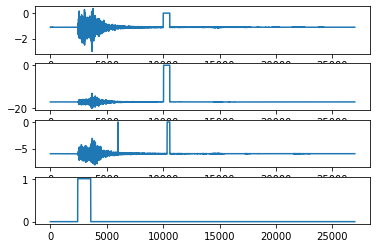

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_FUSS_FBA


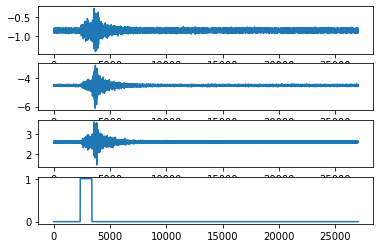

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NWR_FBA


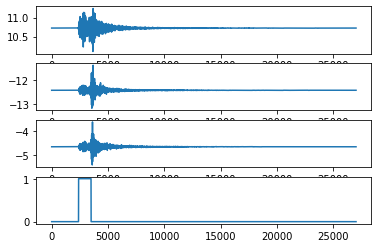

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ZUZH_FBA


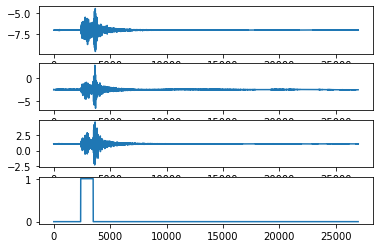

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ZUZH_FBA


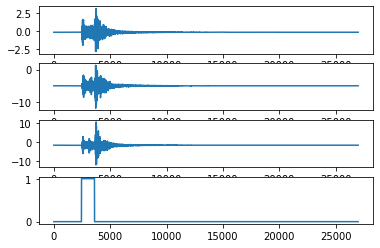

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WHF_FBA


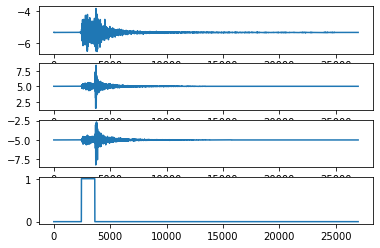

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWS1_FBA


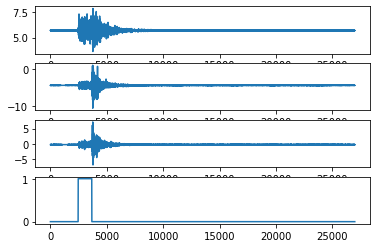

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NTY_FBA


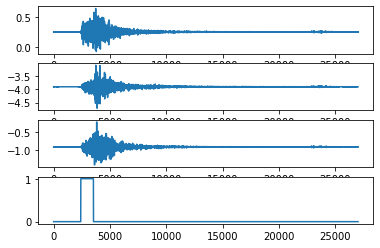

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ANP_FBA


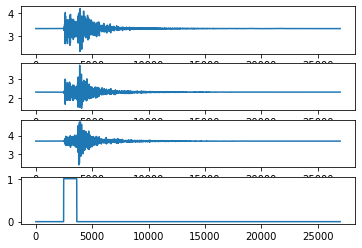

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_KSHI_FBA


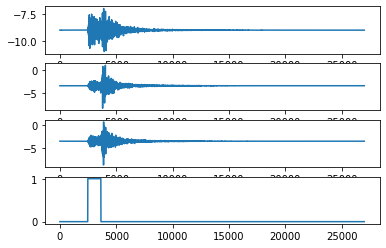

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_KSHI_FBA


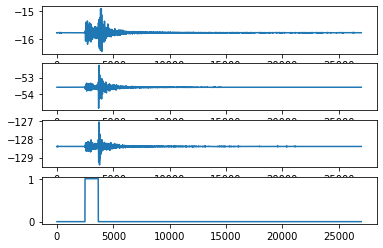

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NFF_FBA


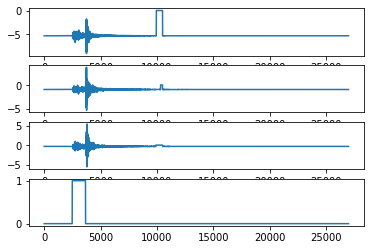

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NFF_FBA


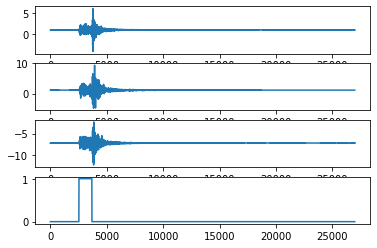

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWT_FBA


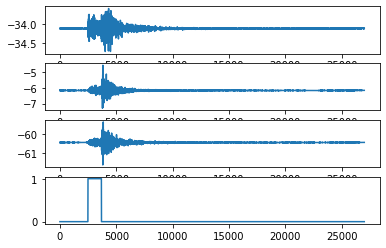

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NTS_FBA


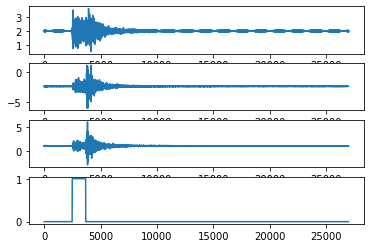

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NTS_FBA


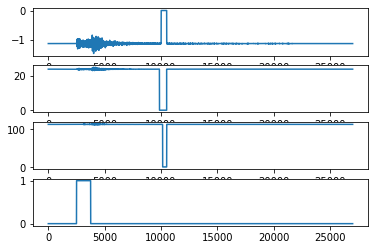

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SHUL_FBA


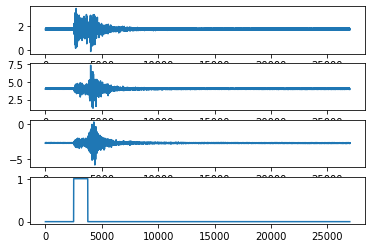

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SHUL_FBA


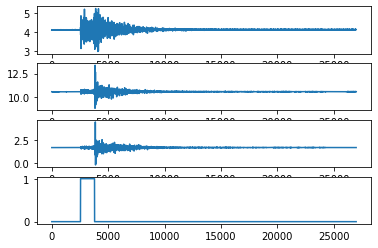

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NCU_FBA


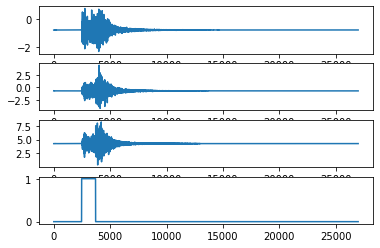

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ESL_FBA


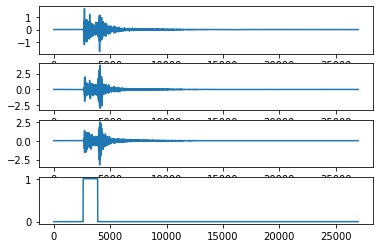

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_LIOB_FBA


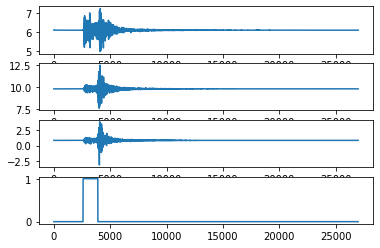

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NST_FBA


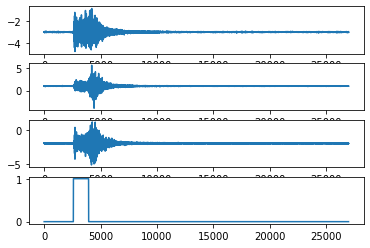

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EGC_FBA


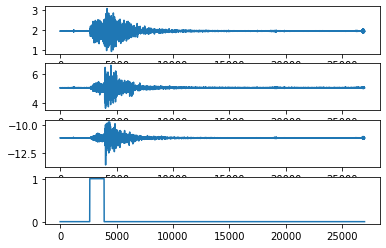

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_HSN1_FBA


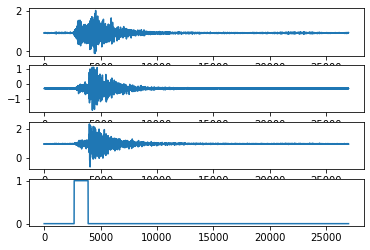

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_HSN_FBA


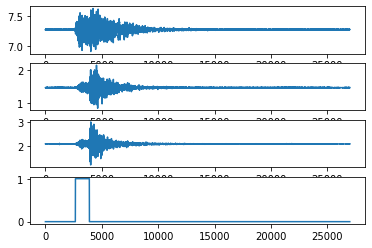

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_HSN_FBA


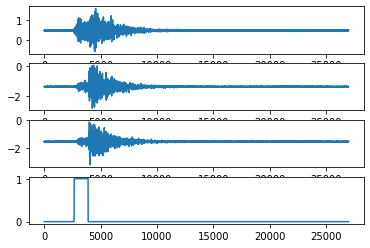

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_HSN_FBA


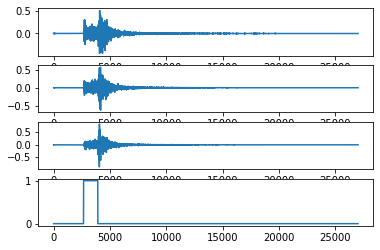

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_OWD_FBA


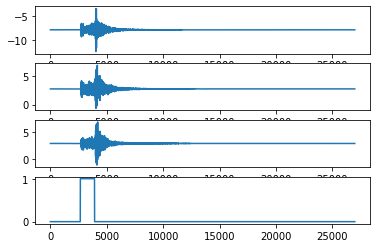

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_OWD_FBA


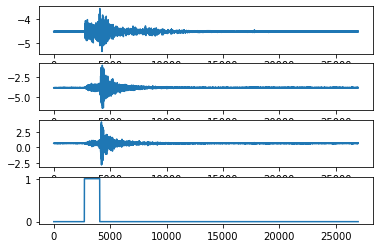

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NHW_FBA


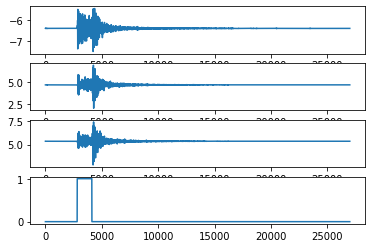

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WHP_FBA


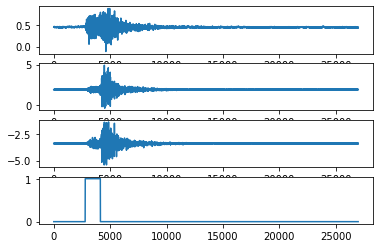

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NJN_FBA


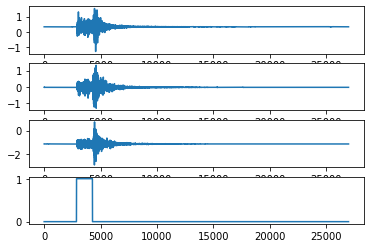

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WPL_FBA


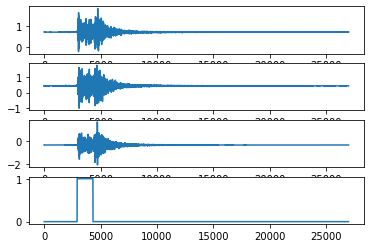

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_DPDB_FBA


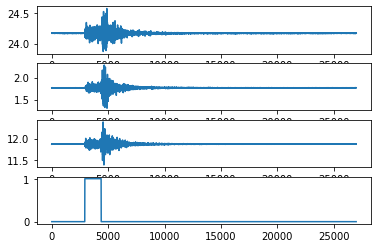

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCS_FBA


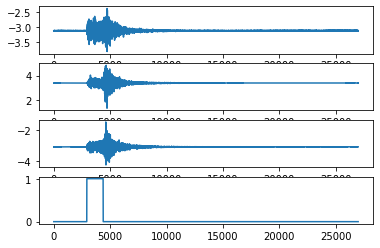

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCS_FBA


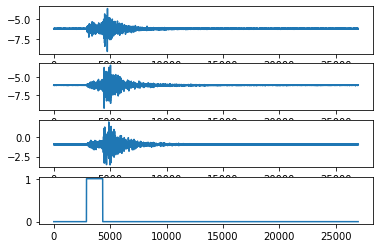

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NMLH_FBA


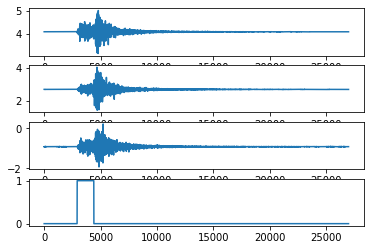

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWQ1_FBA


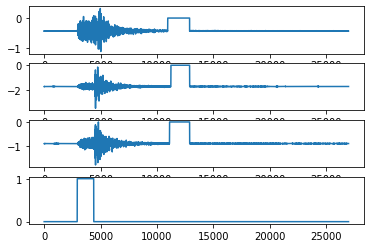

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_NSY_FBA


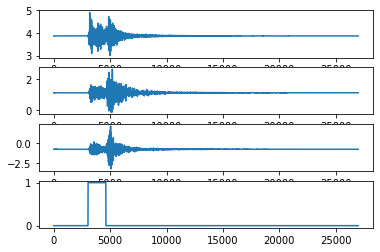

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SML_FBA


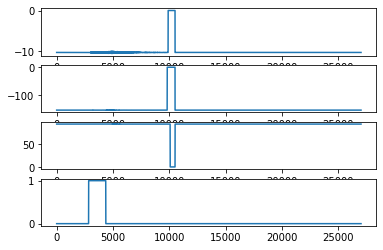

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EHYH_FBA


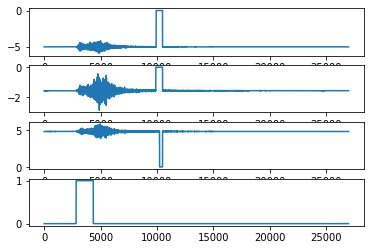

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EHYH_FBA


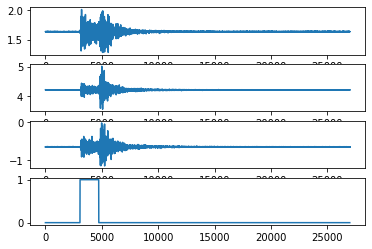

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TYC_FBA


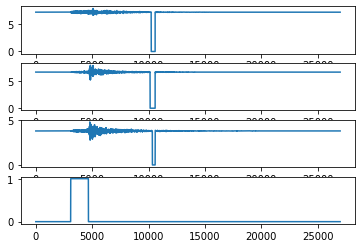

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WDJ_FBA


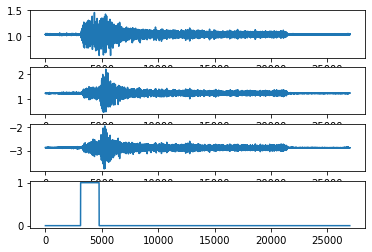

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TCU_FBA


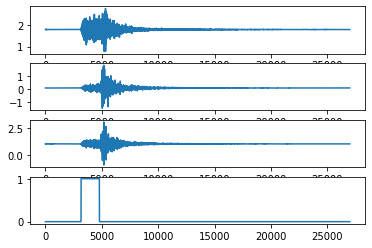

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WWF_FBA


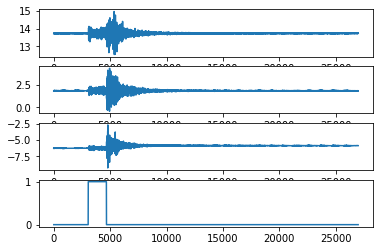

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ECB_FBA


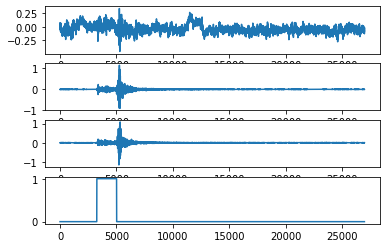

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WHY_FBA


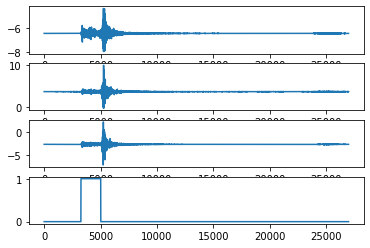

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WHY_FBA


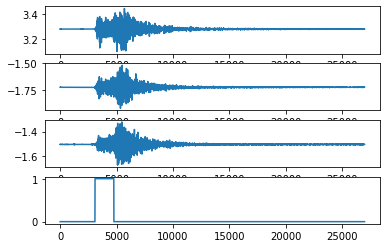

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EYUL_FBA


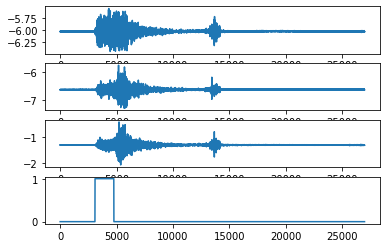

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EYUL_FBA


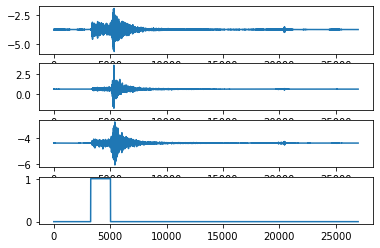

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WNT1_FBA


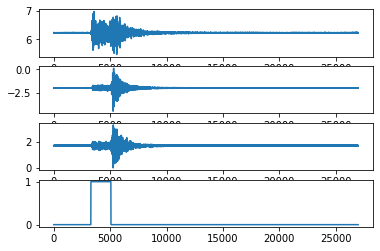

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WNT_FBA


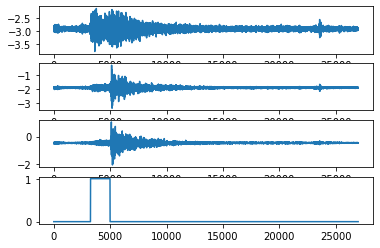

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WWC_FBA


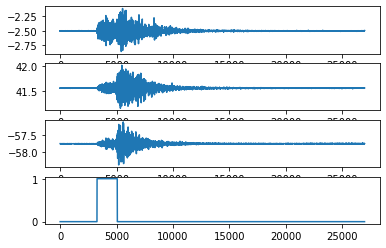

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCHH_FBA


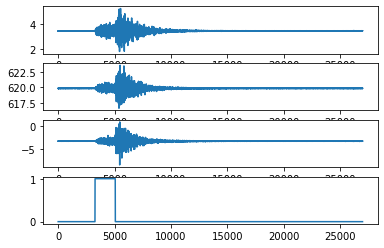

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCHH_FBA


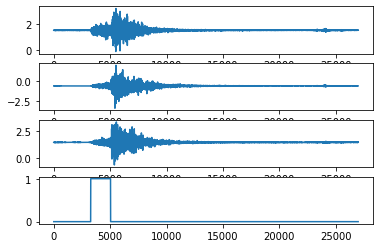

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCH1_FBA


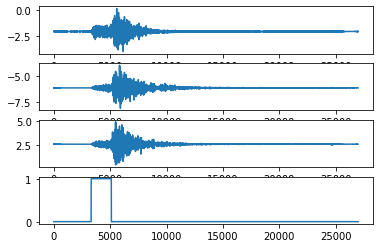

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WYL_FBA


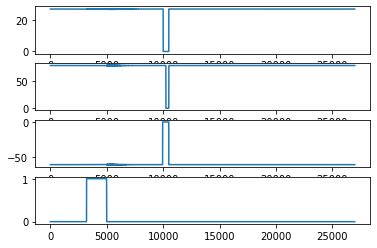

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHKH_FBA


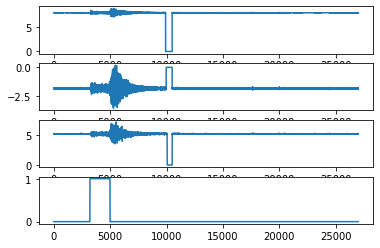

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHKH_FBA


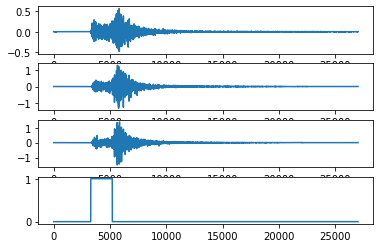

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_FULB_FBA


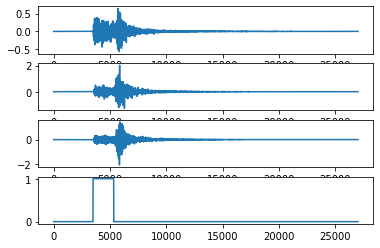

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ALS_FBA


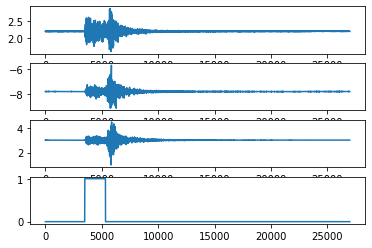

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ALS_FBA


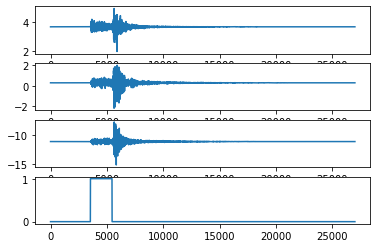

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHN5_FBA


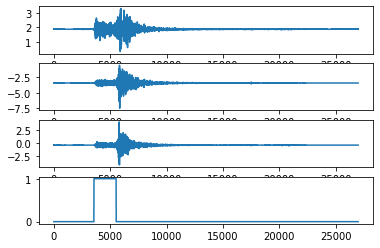

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WGK_FBA


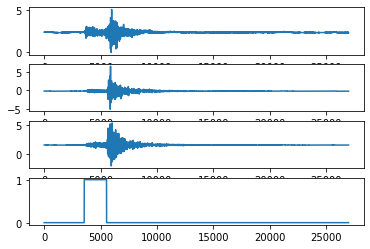

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WDL_FBA


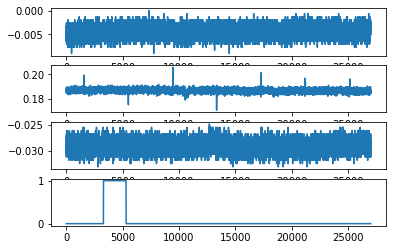

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EHD_FBA


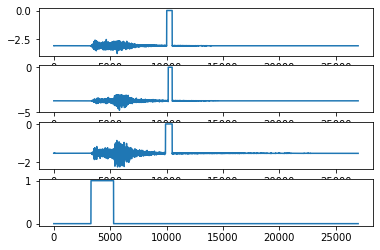

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EHD_FBA


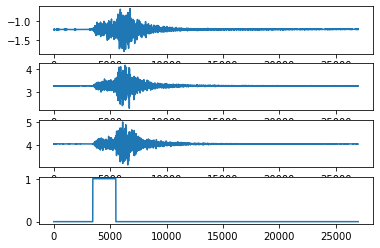

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ECS_FBA


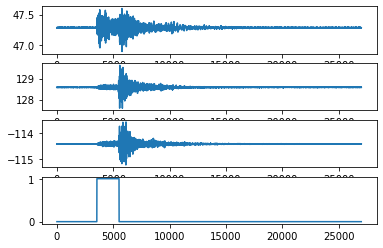

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WRL_FBA


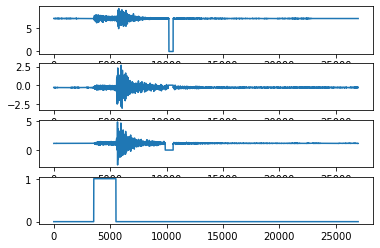

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WRL_FBA


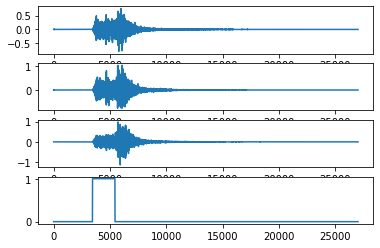

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ELD_FBA


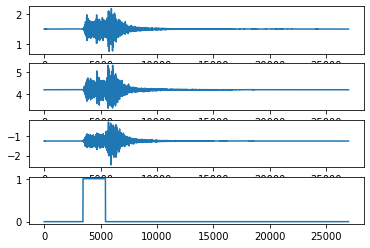

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ELD_FBA


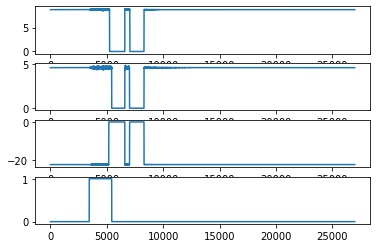

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ELD_FBA


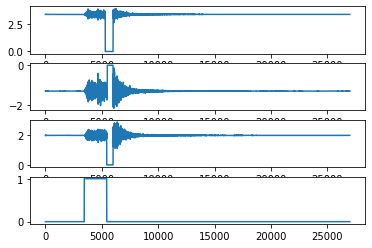

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ELD_FBA


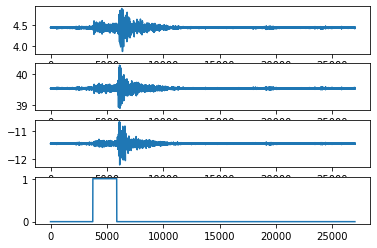

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCKO_FBA


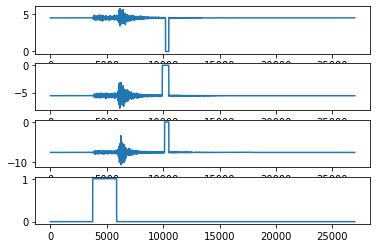

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WCKO_FBA


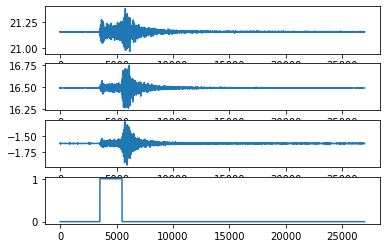

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EDH_FBA


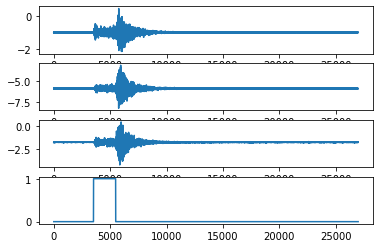

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_EDH_FBA


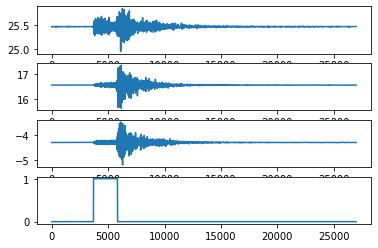

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WTK_FBA


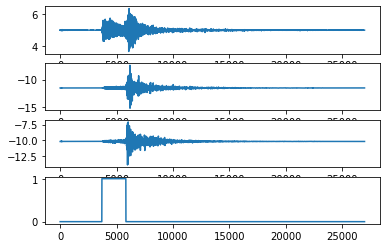

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WTK_FBA


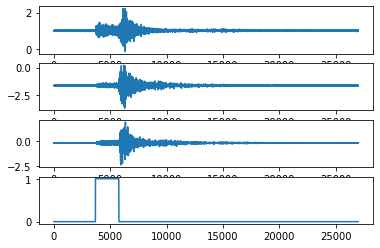

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WTC_FBA


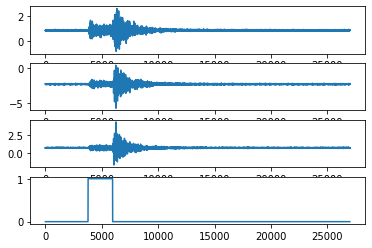

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHN2_FBA


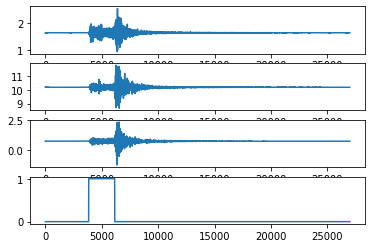

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHN4_FBA


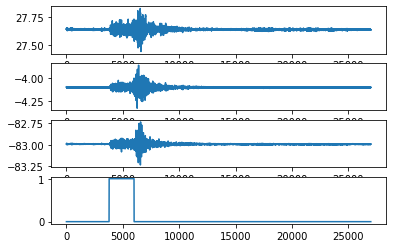

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_STYH_FBA


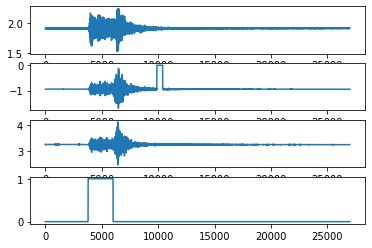

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_STYH_FBA


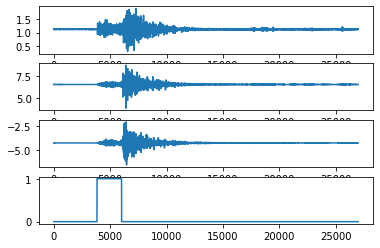

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHY_FBA


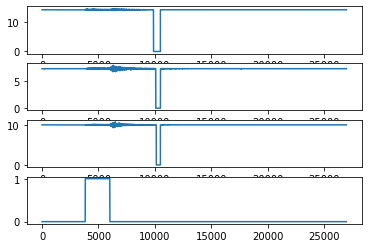

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHY_FBA


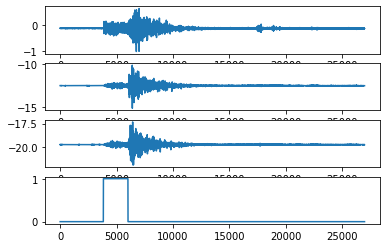

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHY_FBA


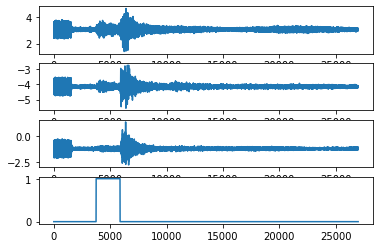

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WML_FBA


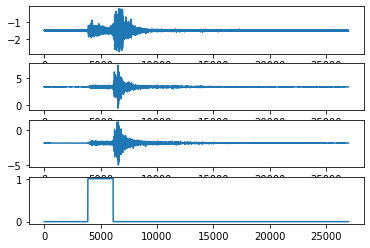

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WSF_FBA


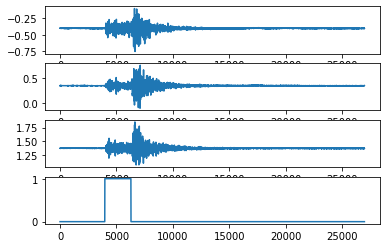

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TWL_FBA


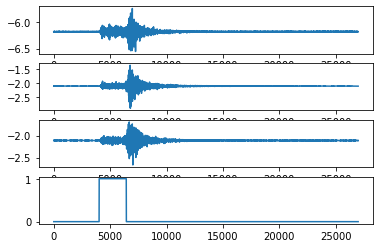

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHN1_FBA


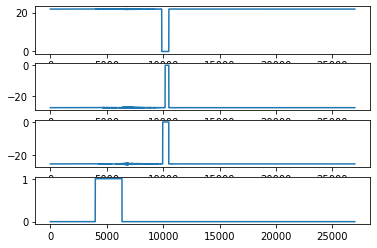

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WSL_FBA


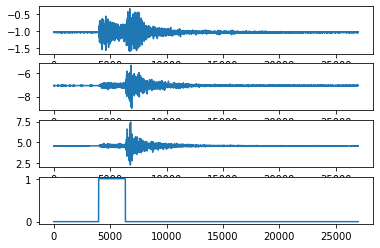

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_WSL_FBA


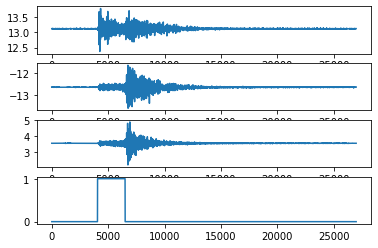

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ICHU_FBA


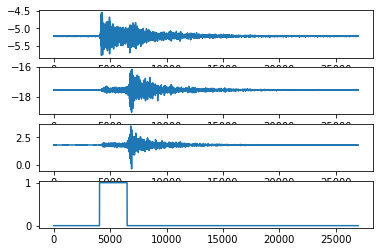

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_ICHU_FBA


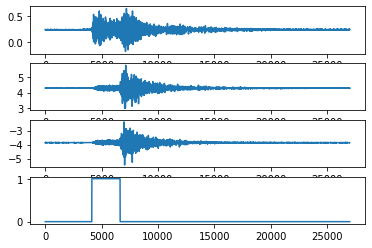

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHN8_FBA


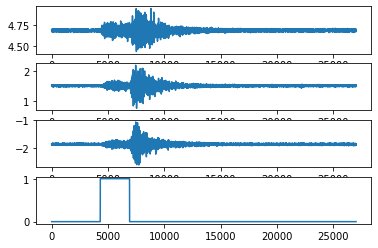

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_CHN3_FBA


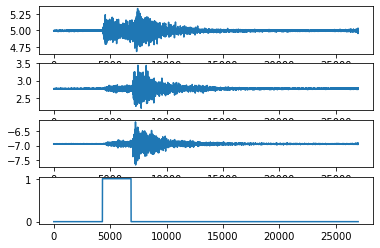

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SSH_FBA


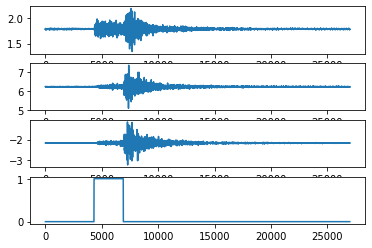

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SCL_FBA


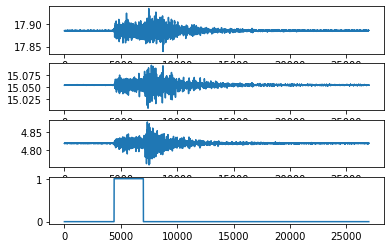

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SCS_FBA


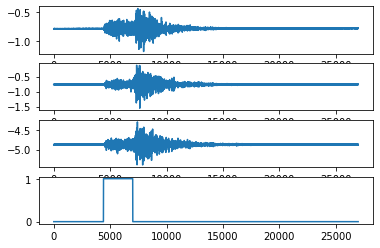

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SCS_FBA


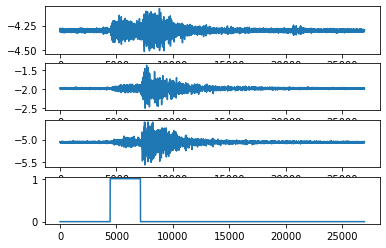

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_TAI1_FBA


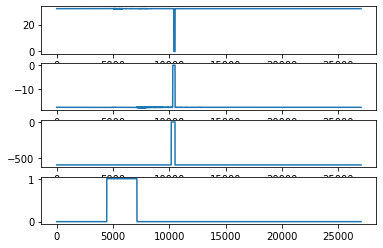

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SCK_FBA


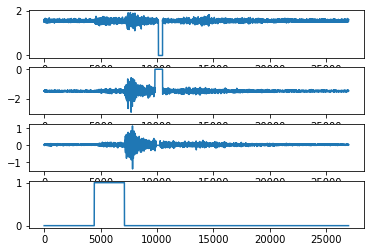

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SCK_FBA


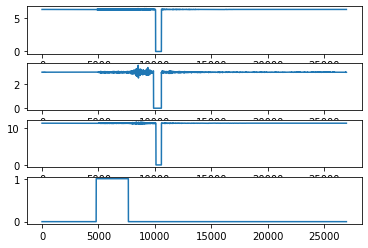

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_SSP_FBA


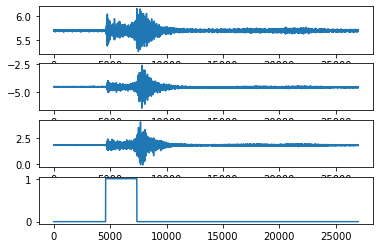

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_LAY_FBA


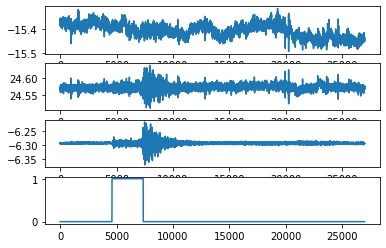

/mnt/nas7/weiwei/earthquake_RNN/newTrain/seis/20201210181508_LAY_FBA


In [45]:
for f in files:
    f = open(os.path.join(root, f), 'r')
    p = json.load(f)
    
    getSeisWave(p, root_save_path)
    break